In [1]:
import pandas as pd
import numpy as np

import datetime
from collections import defaultdict
import itertools as it
from typing import Callable, List

import pathlib
import _pickle as cpickle

import scipy.stats as st
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error

from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [2]:
rc('font', **{'family':'sans-serif'})
rc('text', usetex=False)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

lw = 2.25
fs = 10.0
al = 0.95

foc_m_cols = {'solo':'#777777', 0:'#0B9A85', 1:"#76C1CA"}
foc_d_cols = {'solo':'#222222', 0:'#105C51', 1:"#208896"}
multi_cols = {0:'#008795',1:'#629CC0',6:'#C8C0DD',2:'#DEA8AB',
              3:'#FFC980',5:'#E3EA7A',4:'#76C1CA',7:'#999999'}

label_cols = {'main':'#111111', 'accent':'#C69F52', 'tick':'#333333'}

cmaa = plt.cm.viridis

pe_dat_l = [path_effects.Stroke(linewidth=lw*1.5,foreground='#FFFFFF',alpha=al),
            path_effects.Normal()]
pe_dat_d = [path_effects.Stroke(linewidth=lw*1.5,foreground='#111111',alpha=al),
            path_effects.Normal()]
pe_lab_l = [path_effects.Stroke(linewidth=1.0, foreground='#FFFFFF'),
            path_effects.Normal()]
pe_lab_d = [path_effects.Stroke(linewidth=1.0, foreground='#111111'),
            path_effects.Normal()]

In [3]:
today = str(datetime.datetime.date(datetime.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
dates = DATERANGE.copy()

date_dict = dict(zip(DATE_DF['date'].values,list(range(DATE_DF.shape[0]))))

In [4]:
try:
    from skforecast.ForecasterAutoreg import ForecasterAutoreg
    from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
    import xgboost as xgb
except:
    !pip install skforecast xgboost
    from skforecast.ForecasterAutoreg import ForecasterAutoreg
    from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
    import xgboost as xgb

In [5]:
def walk_forward(regressor:Callable,
                 df:pd.DataFrame,
                 end_train:datetime.datetime,
                 target_col:str, lags:int,
                 exog_cols:List[str]=None,
                 forecast_steps:int=21, n_boot=100)->List[pd.DataFrame]:
    
    if exog_cols is not None:
        exog_df= df[exog_cols]
    else:
        exog_df=None
    
    
    forecast_dt= datetime.timedelta(days=forecast_steps)
    
    one_day= datetime.timedelta(days=1)
    
    forecaster= ForecasterAutoreg(regressor, lags=lags)
    
    predictions=[]
    
    n_train= len(df.loc[:end_train])

    for c, i in enumerate(range(n_train, len(df))) :
        
        end_train+= one_day

        forecaster.fit(df.loc[:end_train, target_col],
                      exog= exog_df.loc[:end_train] if exog_cols is not None else None)

        end_forecast= end_train+ forecast_dt
        
        steps= min(len(df.loc[end_train:end_forecast]), 21)
                  
        if steps==0:
            break
            

        df_pred=forecaster.predict(steps=steps, 
                                   exog=exog_df.loc[end_train:end_forecast] if exog_cols is not None else None)
        
        predictions.append(df_pred.to_frame("pred"))
    
    #    
    return predictions

In [6]:
def get_forecast_by_steps(predictions):

    forecast_by_steps=[]

    steps2pred= defaultdict(list)


    for i, pred in enumerate(predictions):
        for j , row in enumerate(pred.iterrows()): 
            steps2pred[j].append((row[0], row[1].pred))

    for k in steps2pred:
        df_tmp=pd.DataFrame(steps2pred[k]).set_index(0).rename(columns={1:"pred"})
        df_tmp.index.name=None
        sigma=df_tmp["pred"].apply(np.sqrt)
        df_tmp["lower_bound"]= df_tmp["pred"]- 1.96*sigma
        df_tmp["upper_bound"]=df_tmp["pred"]+ 1.96*sigma
        forecast_by_steps.append(df_tmp)

    return forecast_by_steps

In [7]:
def get_metrics(target_col, df, forecast_by_steps, forecast_by_steps_exog):
    nums= [0, 6, 13, 20]
    extra_21_days= datetime.timedelta(days=20)

    mse=[]
    mse_exog=[]

    mae=[]
    mae_exog=[]

    for n in nums:
        steps= datetime.timedelta(n+1)
        mse.append(mean_squared_error(df.loc[end_train+steps:, target_col].values,
                                      forecast_by_steps[n].pred.values))
        mse_exog.append(mean_squared_error(df.loc[end_train+steps:, target_col].values,
                                           forecast_by_steps_exog[n].pred.values))

        mae.append(mean_absolute_error(df.loc[end_train+steps:, target_col].values,
                                       forecast_by_steps[n].pred.values))
        mae_exog.append(mean_absolute_error(df.loc[end_train+steps:, target_col].values,
                                            forecast_by_steps_exog[n].pred.values))


    metrics_df= pd.DataFrame(index=[n+1 for n in nums],
                             data={"MSE":mse,
                                   "MSE-exog":mse_exog,
                                   "MAE":mae,
                                   "MAE-exog":mae_exog})
    metrics_df.index.name= "days"
    return metrics_df

In [8]:
def save_predictions(filePath, forecast_by_steps, nums=[0, 6, 13, 20]):
    for n in nums:
        data={"{}".format(n+1): forecast_by_steps[n]}
    cpickle.dump(data, open(filePath, 'wb'))
#
def load_predictions(filePath):
    return cpickle.load(filePath)

In [9]:
def plot_compare(target_col, forecast_by_steps, forecast_by_steps_exog):

  fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
  axs= ax.ravel()

  nums= [0, 6, 13, 20]
  sublabels=["(a)", "(b)", "(c)", "(d)"]

  for i, n in enumerate(nums):
    df[target_col].plot(ax=axs[i], color="black", legend=False, linestyle="dotted")
    df[target_col].rolling("7D").mean().plot(ax=axs[i], color="red", legend=False)
    forecast_by_steps[n].pred.shift(-n).plot(linestyle="--", marker="x", ax=axs[i], color="blue", legend=False)
    forecast_by_steps_exog[n].pred.shift(-n).plot(linestyle="-.", marker="v", ax=axs[i], color="orange", legend=False, alpha=.7)
    axs[i].set_title(f"{n+1}-days forecast")
    axs[i].set_ylabel("No. Admissions")
    axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1], s=sublabels[i], fontweight="bold", fontsize=12)
    axs[i].set_ylim(ymin=0)
    axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0], ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--")
  #
  axs[1].legend(["True", "7-day MA", "No mobility", "with mobility"], bbox_to_anchor=[1.05, .6])
  fig.suptitle(f"Hospital {target_col}")
  return fig, ax

In [10]:
def plot_compare_rolling(target_col, forecast_by_steps, forecast_by_steps_exog):

  fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
  axs= ax.ravel()

  nums= [0, 6, 13, 20]
  sublabels=["(a)", "(b)", "(c)", "(d)"]
    
  for i, n in enumerate(nums):
    df[target_col].rolling("7D").mean().plot(ax=axs[i], color="red", legend=False)
    forecast_by_steps[n].rolling("7D").mean().pred.shift(-n).plot(linestyle="--",
                                                                  marker="x", ax=axs[i],
                                                                  color="blue", legend=False)
    forecast_by_steps_exog[n].rolling("7D").mean().pred.shift(-n).plot(linestyle="-.",
                                                                       marker="v", ax=axs[i],
                                                                       color="orange", legend=False, alpha=.7)
    axs[i].set_title(f"{n+1}-days forecast")
    axs[i].set_ylabel("No. Admissions")
    axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1], s=sublabels[i], fontweight="bold", fontsize=12)
    axs[i].set_ylim(ymin=0)
    axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0], ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--")
  #
  axs[1].legend(["7-day MA", "7-day MA forecast-No mobility",
                 "7-day MA forecast-with mobility"], bbox_to_anchor=[1.05, .6])
  fig.suptitle(f"Hospital {target_col}")
  return fig, ax

In [11]:
def plot_with_ci(target_col, df, forecast_by_steps):

    fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
    axs= ax.ravel()

    nums= [0, 6, 13, 20]
    sublabels=["(a)", "(b)", "(c)", "(d)"]

    for i, n in enumerate(nums):
        df[target_col].plot(ax=axs[i], color="black", legend=False, linestyle="dotted")
        forecast_by_steps[n].pred.shift(-n).plot(linestyle="--", marker="x",
                                                 ax=axs[i], color="orange", legend=False)

        axs[i].set_title(f"{n+1}-day forecast")
        axs[i].set_ylabel("No. Admissions")

        x= forecast_by_steps[n].index.to_list()
        y1= forecast_by_steps[n].shift(-n).lower_bound.clip(lower=0).values
        y2= forecast_by_steps[n].shift(-n).upper_bound.clip(lower=0).values

        axs[i].fill_between(x=x, y1=y1, y2=y2, alpha=.3, color="green")
        axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1],
                    s=sublabels[i], fontweight="bold", fontsize=12)
        axs[i].set_ylim(ymin=0)
        axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0],
                      ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--")
    #
    axs[1].legend(["True", "Forecast", "95% CI"], bbox_to_anchor=[1.05, .6])
    return fig, ax

In [12]:
def plot_with_ci_rolling(target_col, df, forecast_by_steps):

    fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
    axs= ax.ravel()

    nums= [0, 6, 13, 20]
    sublabels=["(a)", "(b)", "(c)", "(d)"]
    
    for i, n in enumerate(nums):
        df[target_col].rolling("7D").mean().plot(ax=axs[i], color="red",
                                                 legend=False, linestyle="dotted")
        forecast_by_steps[n].rolling("7D").mean().pred.shift(-n).plot(linestyle="--",
                                                                      marker="x", ax=axs[i],
                                                                      color="orange", legend=False)

        axs[i].set_title(f"{n+1}-day forecast")
        axs[i].set_ylabel("No. Admissions")

        x= forecast_by_steps[n].index.to_list()
        y1= forecast_by_steps[n].rolling("7D").mean().shift(-n).lower_bound.clip(lower=0).values
        y2= forecast_by_steps[n].rolling("7D").mean().shift(-n).upper_bound.clip(lower=0).values
        axs[i].fill_between(x=x, y1=y1, y2=y2, alpha=.3, color="green")
        axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1],
                    s=sublabels[i], fontweight="bold", fontsize=12)
        axs[i].set_ylim(ymin=0)
        axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0],
                      ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--")
    #
    axs[1].legend(["7-day MA", "7-day MA forecast", "7-day MA-95% CI"], bbox_to_anchor=[1.05, .6])
    return fig, ax

In [13]:
dataPath= "data/"
df_mobility= pd.read_csv(dataPath+"mobility.csv", parse_dates=True, index_col=0)
df_ad= pd.read_csv(dataPath+"admissions.csv", parse_dates= True, index_col=0)
df_test= pd.read_csv(dataPath+"testing.csv", parse_dates= True, index_col=0)

df_mobility= pd.merge(df_mobility, df_test, how="inner", left_index=True, right_index=True)

In [14]:
mobility_cols= ['commuters_per_home_user_percent',
                'inter_region_mobility_percent',
                'distinct_users_with_contacts_percent',
                'total_edges_per_distinct_user_percent',
                'distinct_edges_per_distinct_user_percent',
                'new_testing_7day_avg'] # last one isn't really mobility but just for variables

In [15]:
exog_cols= df_mobility.columns.tolist()+['new_testing_7day_avg']

In [16]:
df_ad=df_ad[df_ad.COVID_Encounter_Ref=="covid_prim"]
groups= df_ad.groupby(pd.Grouper("HospitalID"))
df_hospitalized=pd.DataFrame()

for name, group in groups:
    df_hospitalized[name]= group.NumberOfAdmissions.resample('D').sum()

In [17]:
df_hospitalized.fillna(0, inplace=True)

In [18]:
df_hospitalized= df_hospitalized[["A","B","C","D","E"]]

In [19]:
df= pd.merge(df_mobility, df_hospitalized, how="inner", left_index=True, right_index=True)
df=df.asfreq("D")

In [20]:
# df = pd.merge(df,df_test,how='inner',left_index=True,right_index=True)
df.head()

commuters_per_home_user_percent  inter_region_mobility_percent  \
2020-03-10                         1.073971                       1.000720   
2020-03-11                         1.055047                       0.967856   
2020-03-12                         1.032808                       0.937507   
2020-03-13                         0.895072                       0.799649   
2020-03-14                         0.863119                       0.711217   

            distinct_users_with_contacts_percent  \
2020-03-10                              0.990619   
2020-03-11                              0.966286   
2020-03-12                              0.952656   
2020-03-13                              0.853705   
2020-03-14                              0.762077   

            total_edges_per_distinct_user_percent  \
2020-03-10                               0.772722   
2020-03-11                               0.719021   
2020-03-12                               0.564103   
2020-03-13                               0.466450   
2020-03-14                               0.334582   

            distinct_edges_per_distinct_user_percent  new_testing_7day_avg  \
2020-03-10                                  0.923124              0.237991   
2020-03-11                                  0.890452              0.210356   
2020-03-12                                  0.805503              0.148915   
2020-03-13                                  0.664660              0.103077   
2020-03-14                                  0.525999              0.082944   

              A  B    C    D    E  
2020-03-10  0.0  1  0.0  0.0  0.0  
2020-03-11  0.0  1  0.0  0.0  0.0  
2020-03-12  0.0  0  1.0  0.0  1.0  
2020-03-13  0.0  4  2.0  0.0  0.0  
2020-03-14  0.0  1  0.0  0.0  0.0

____________________

In [21]:
def forecast_each_hospital(df, target_col, exog_cols=None, ndays=21):

    params=dict(objective='count:poisson', n_jobs=-1)
    regressor= xgb.XGBRegressor(**params)


    #hyper paramter tuning
    param_grid= dict(
                 reg_alpha=[0.01, 1, 9, 15, 20], 
                 reg_lambda=[.05, .1, .2], 
                 n_estimators=[500, 1000],
                 max_depth=[3, 5],
                 learning_rate=[.1, .3, .5])
    lags_grid=[1, 7, 14]

    params=dict(objective="reg:squarederror", n_jobs=-1)
    regressor= xgb.XGBRegressor(**params)

    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags = 7)


    end_validation= df.index[0] + datetime.timedelta(days=28)
    
    end_train = end_validation- datetime.timedelta(days=7)


    results_grid = grid_search_forecaster(
            forecaster         = forecaster,
            y                  = df.loc[:end_validation, target_col], # Train and validation data
            exog               = df.loc[:end_validation, exog_cols] if exog_cols is not None else None,       
            param_grid         = param_grid,
            lags_grid          = lags_grid,
            steps              = ndays,
            refit              = False,
            metric             = 'mean_squared_error',
            initial_train_size = int(len(df[:end_train])), # Model is trained with training data
            fixed_train_size   = False,
            return_best        = True,
            verbose            = False)
    
    regressor= forecaster.regressor
    lags= forecaster.lags
    params= regressor.get_params()
    print("lags=",lags)
    print("regressor params=", regressor.get_params())
    # run forecast
    params["objective"]='count:poisson'
    end_train= df.index[0] + datetime.timedelta(days=28)
    predictions= walk_forward(regressor, df, end_train=end_train,
                              target_col=target_col, lags=lags,
                              # target_col=target_col, lags=14,
                              exog_cols=exog_cols, forecast_steps=ndays,
                              n_boot=100)

    return predictions

... processing hospital A
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:54<00:00, 38.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 0.2}
  Backtesting metric: 4.490129918768356

lags= [1 2 3 4 5 6 7]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:30<00:00, 30.31s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 0.2}
  Backtesting metric: 3.7521140698151743

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
... processing hospital B
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:38<00:00, 32.71s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 0.1}
  Backtesting metric: 20.00834940057965

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:35<00:00, 31.77s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.1}
  Backtesting metric: 17.58380718033472

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
... processing hospital C
Number of models compared: 54

loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:28<00:00, 29.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.1}
  Backtesting metric: 18.318205759121934

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:39<00:00, 33.20s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.05}
  Backtesting metric: 17.326335917429756

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.05, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
... processing hospital D
Number of models compared:

loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:37<00:00, 32.61s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.2}
  Backtesting metric: 14.485576123593562

lags= [1 2 3 4 5 6 7]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:31<00:00, 30.61s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.01, 'reg_lambda': 0.05}
  Backtesting metric: 10.393245110659832

lags= [1]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.05, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
... processing hospital E
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:24<00:00, 28.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.2}
  Backtesting metric: 19.18400506687515

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Number of models compared: 540


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:49<00:00, 36.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.2}
  Backtesting metric: 17.212177506576186

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


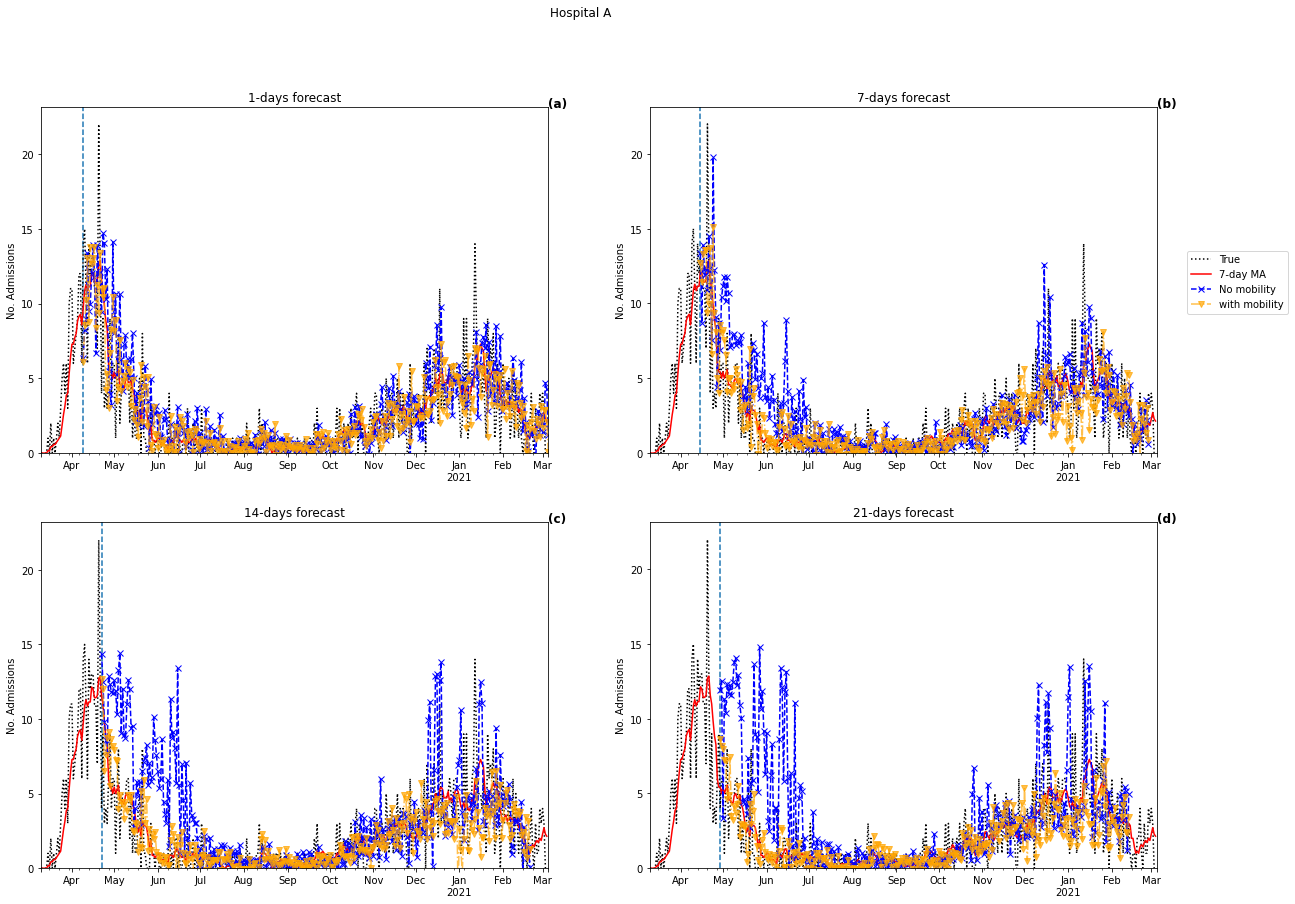

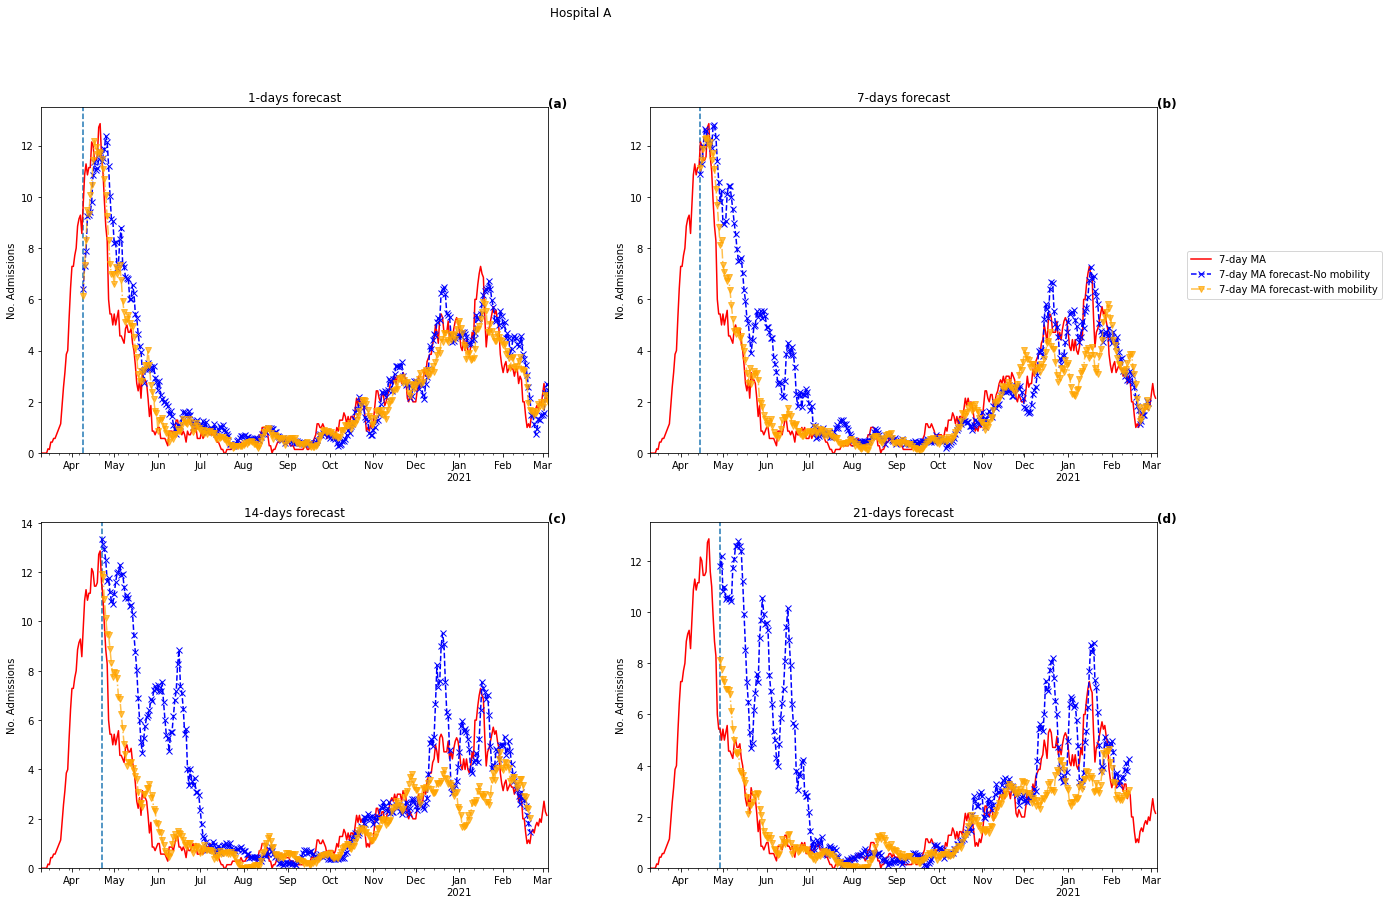

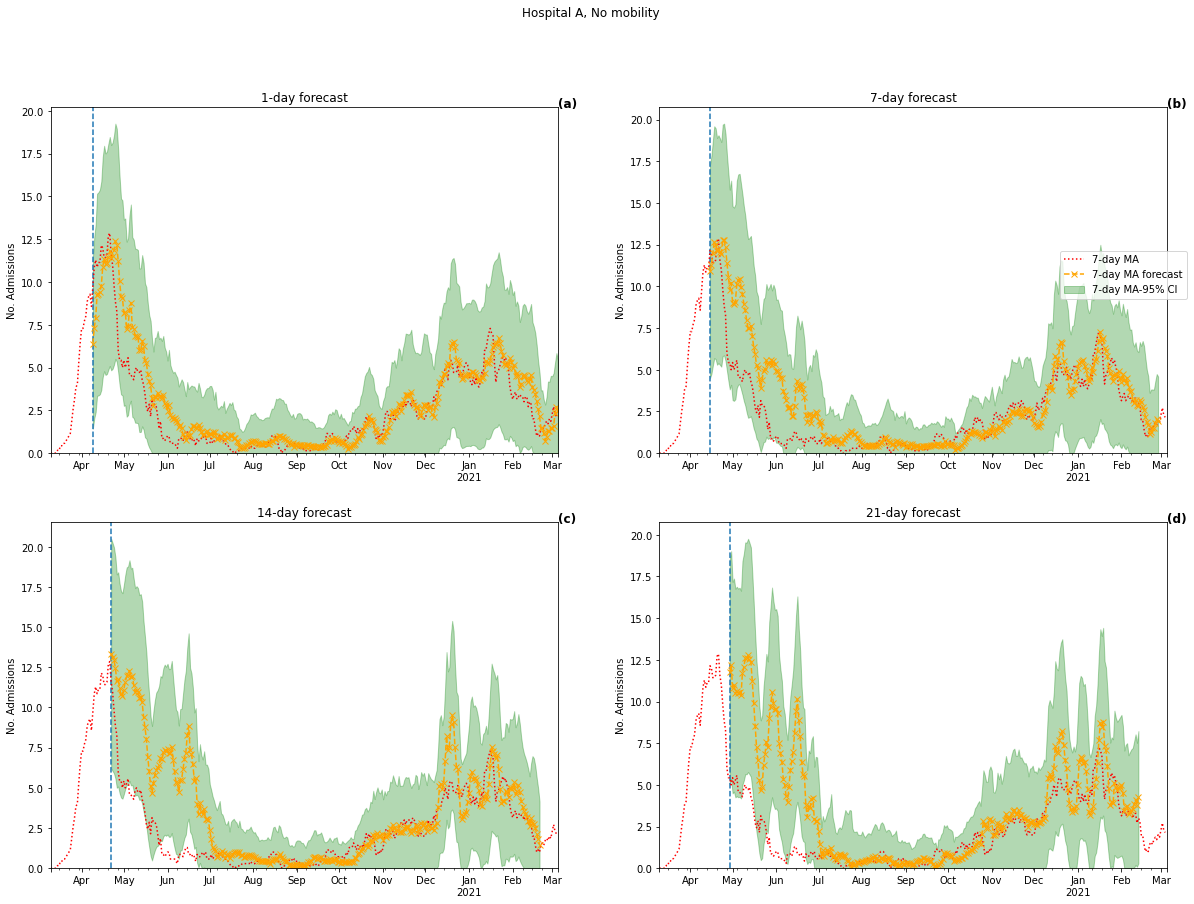

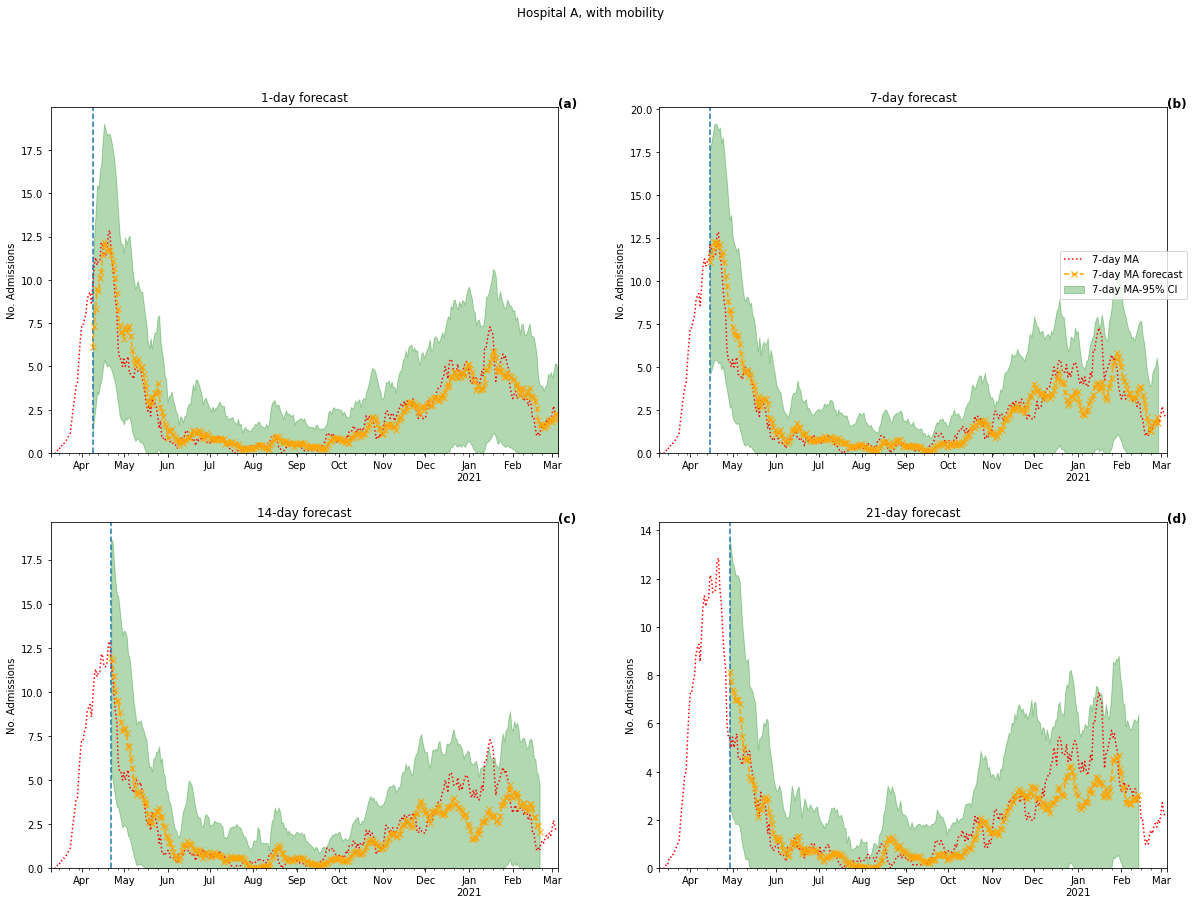

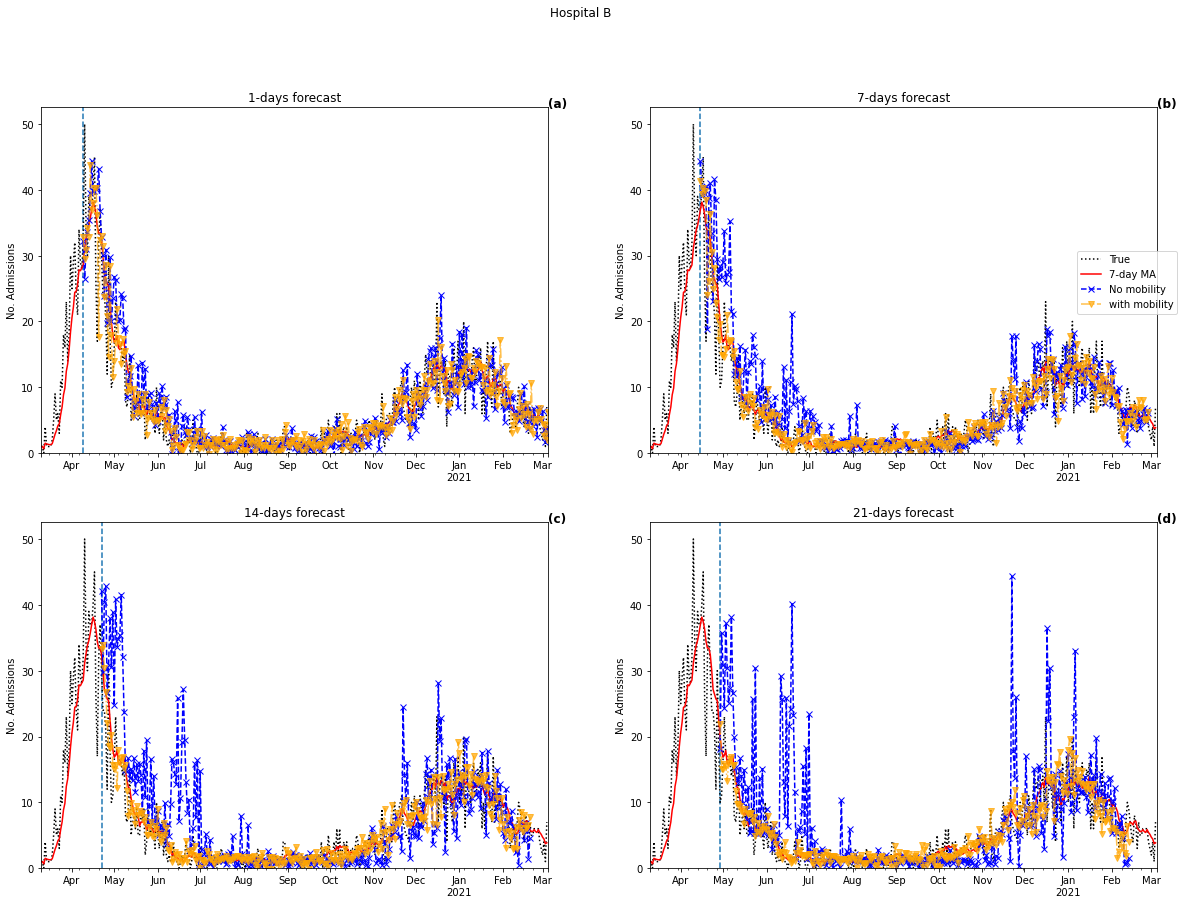

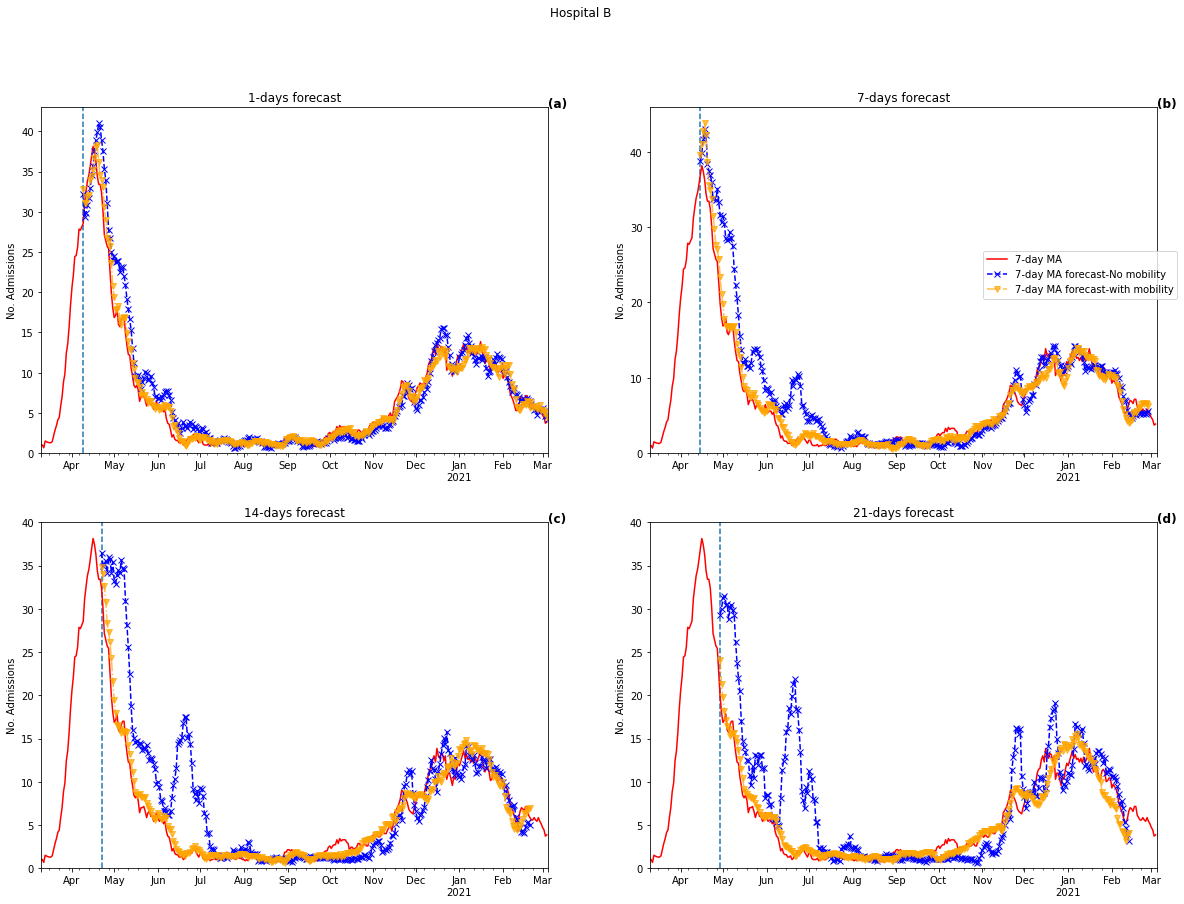

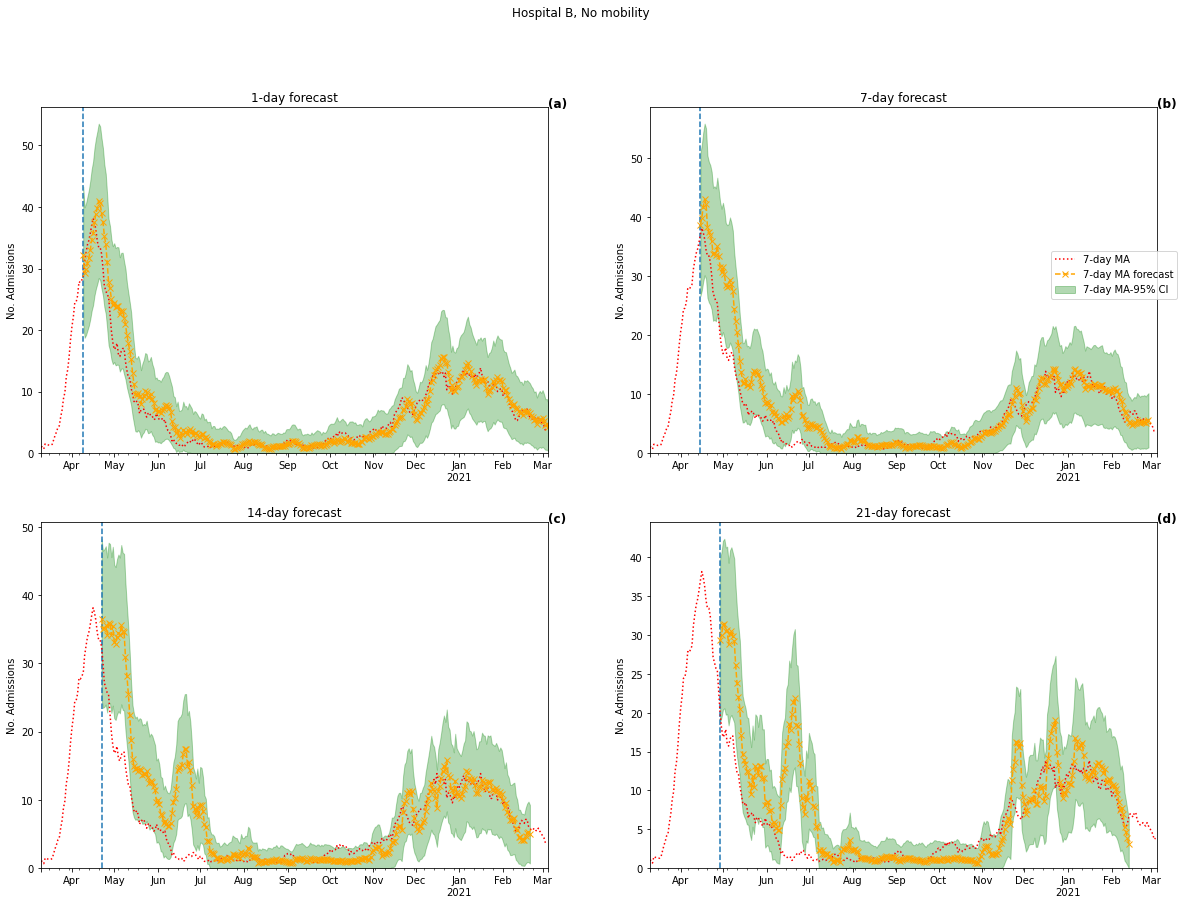

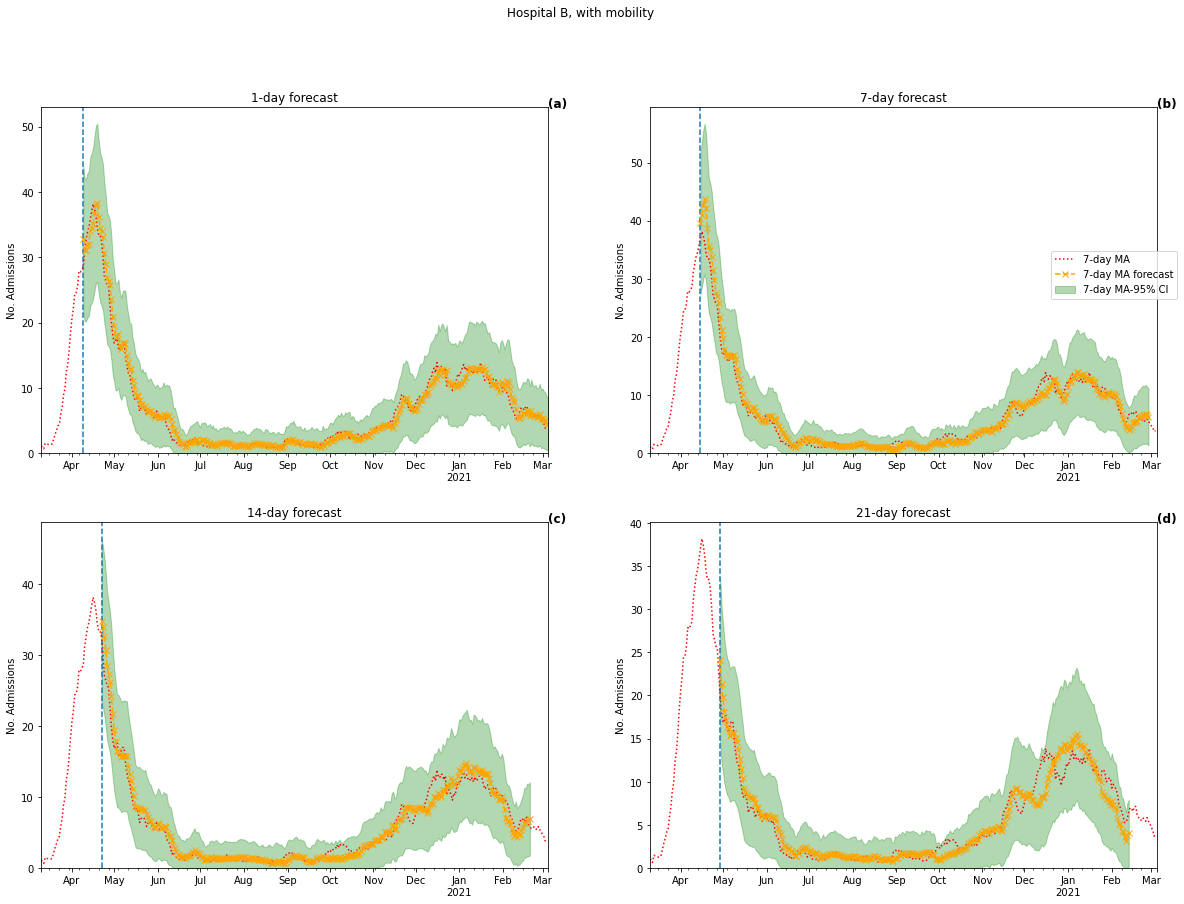

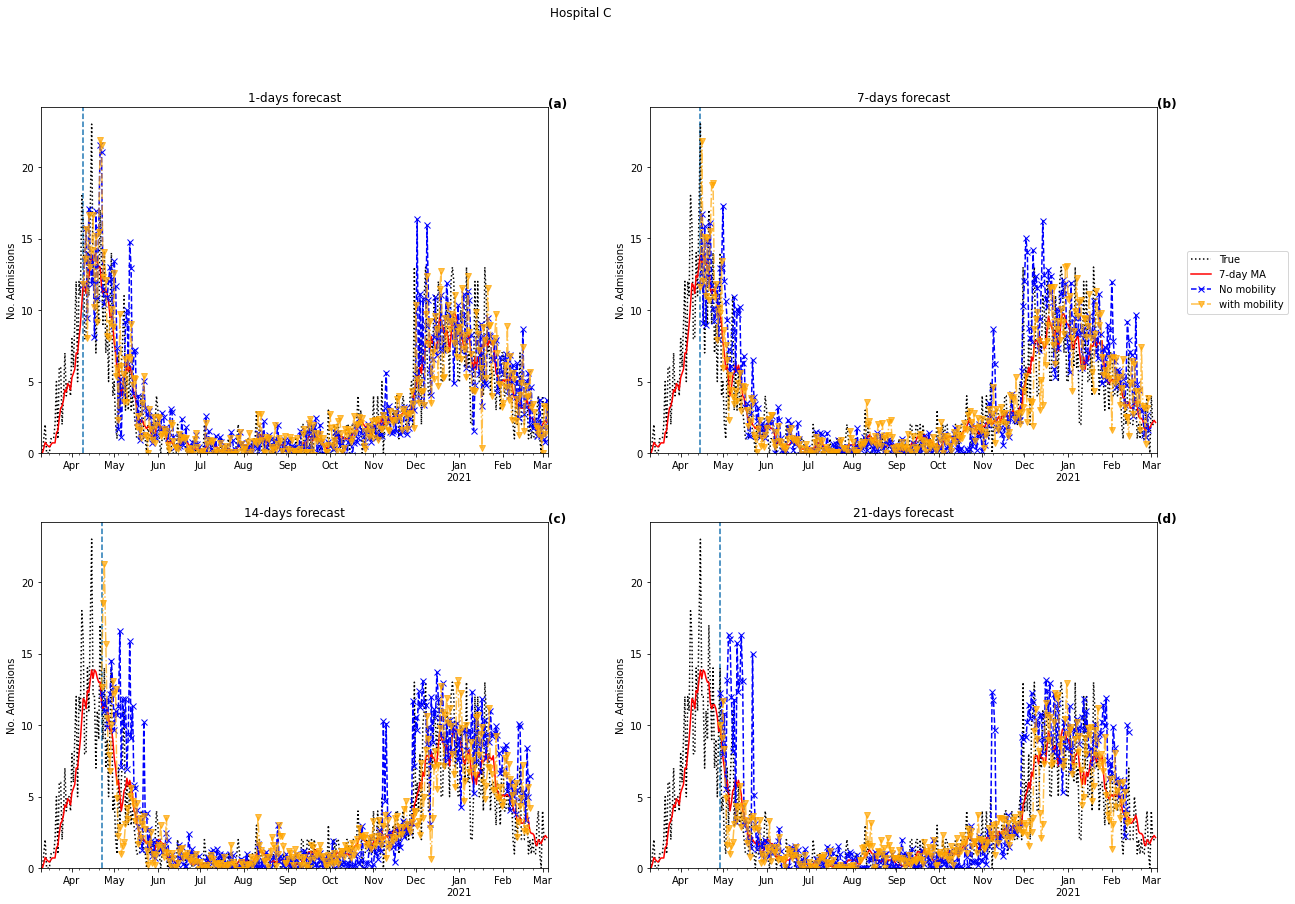

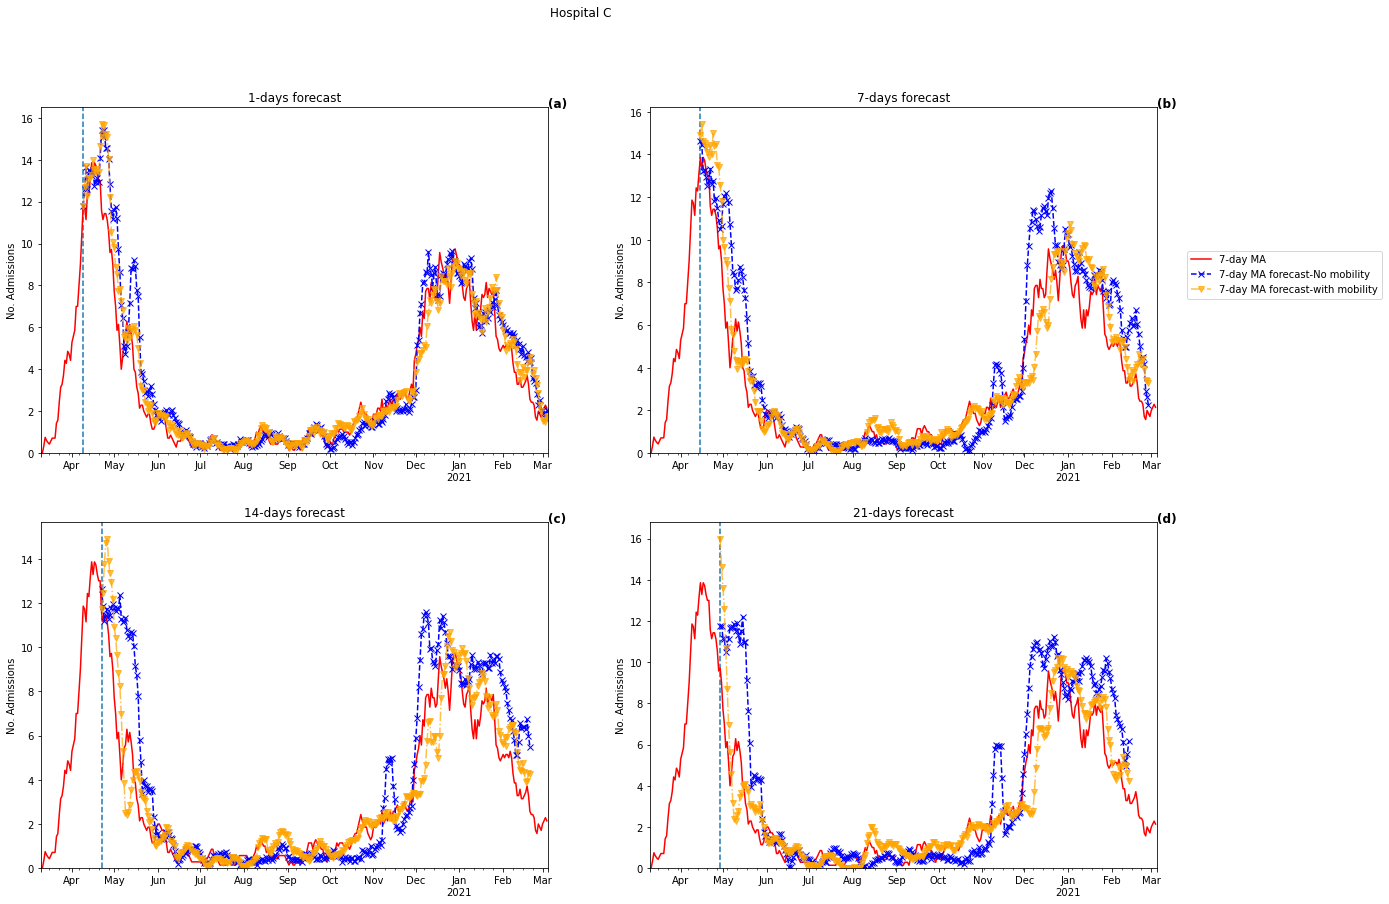

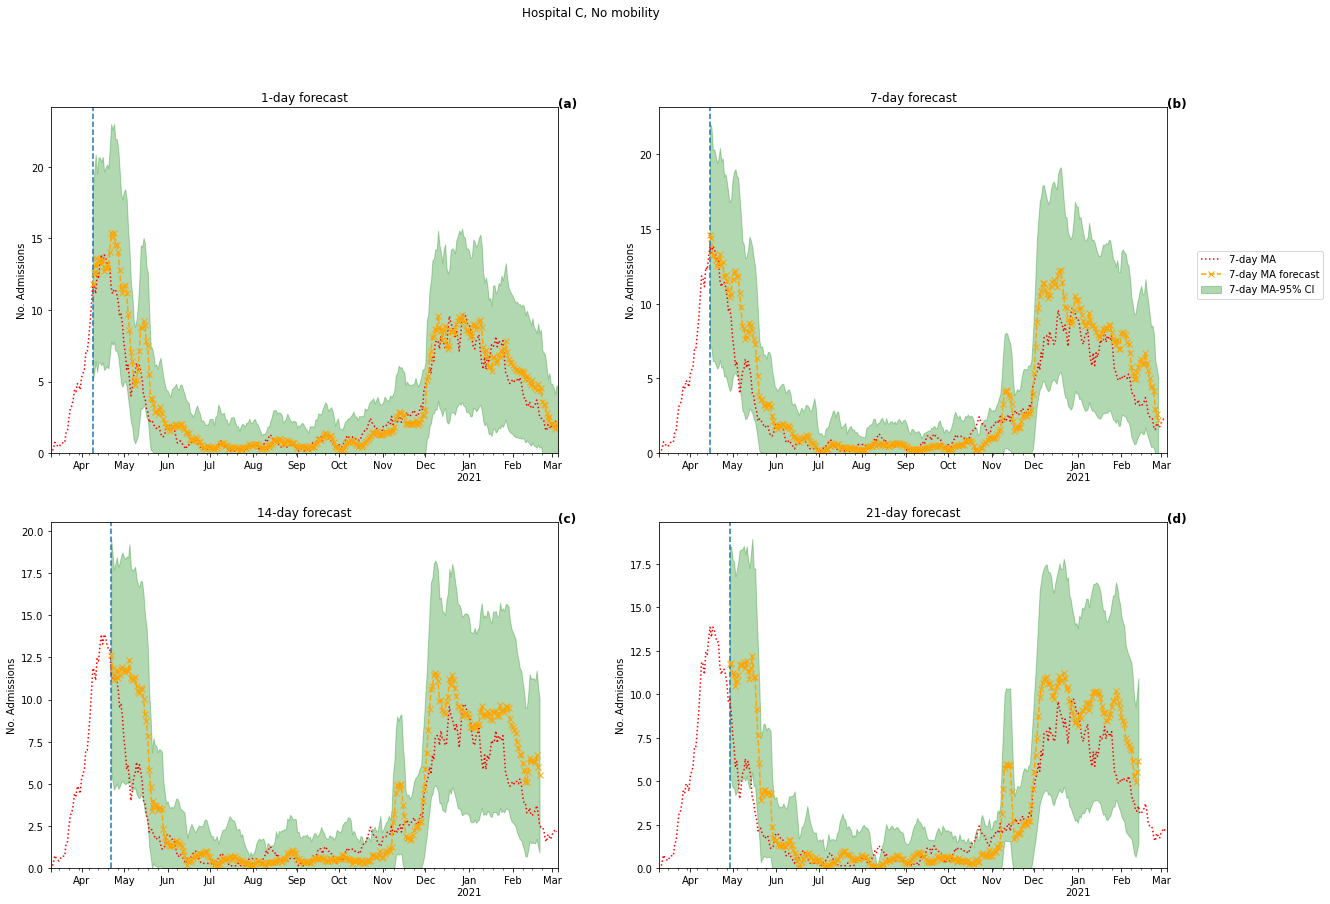

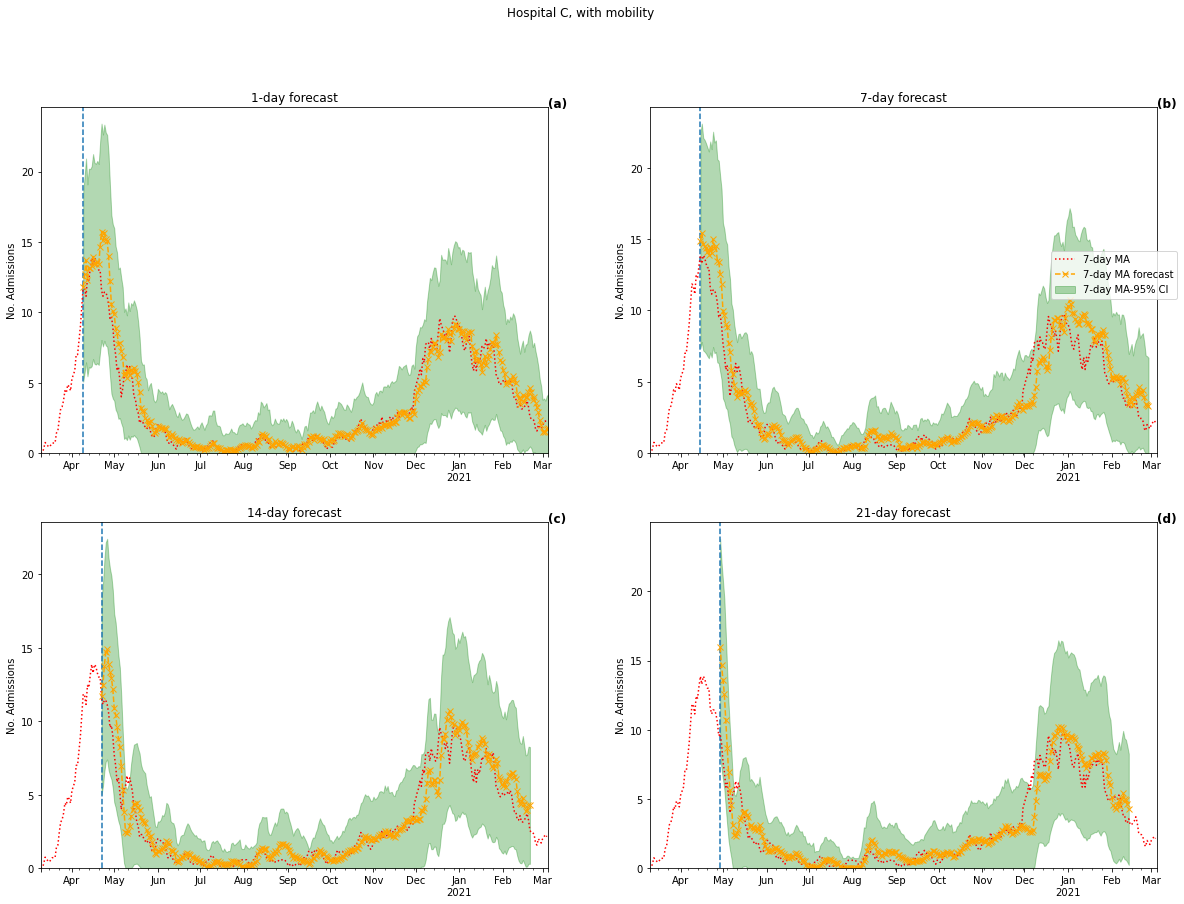

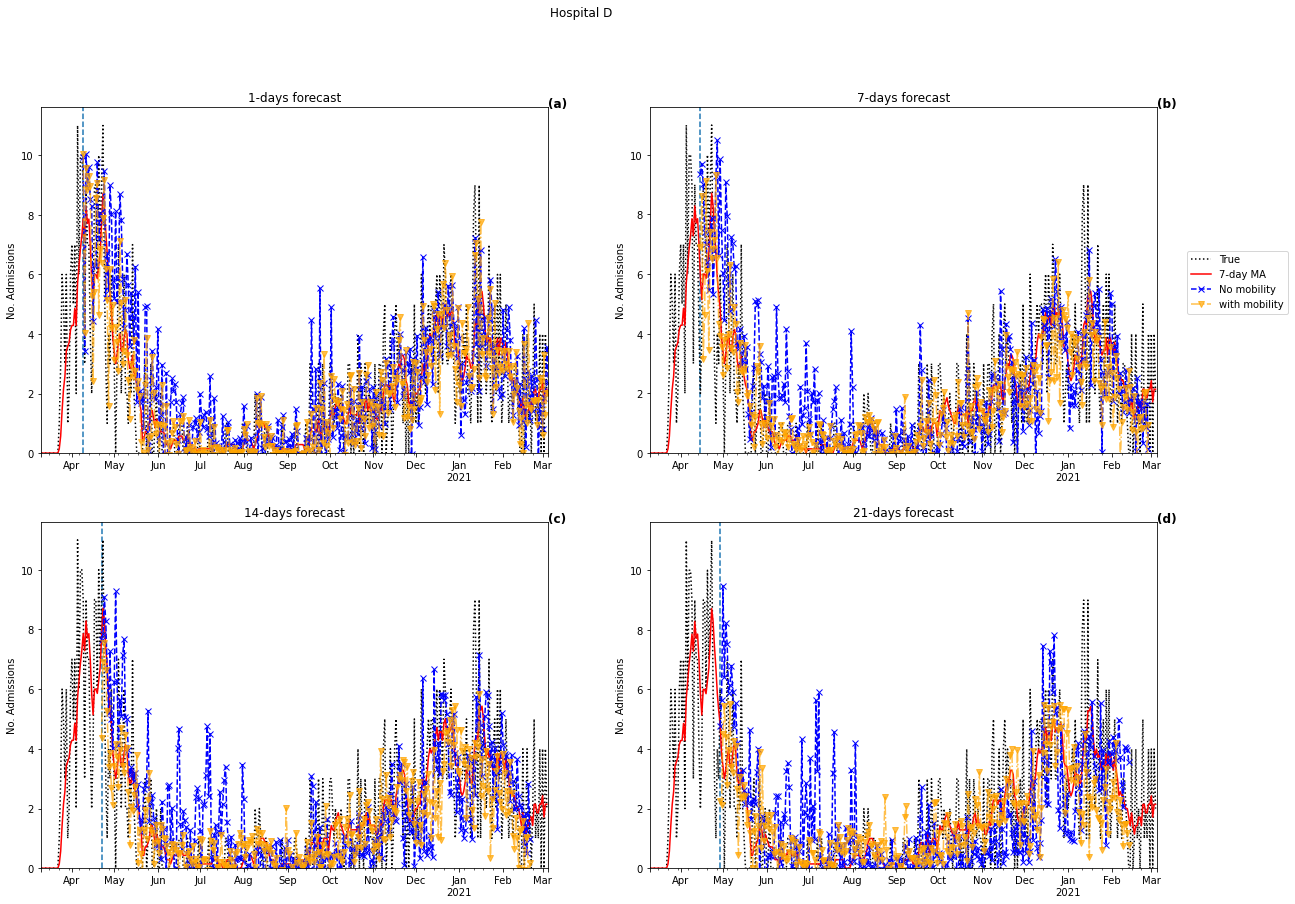

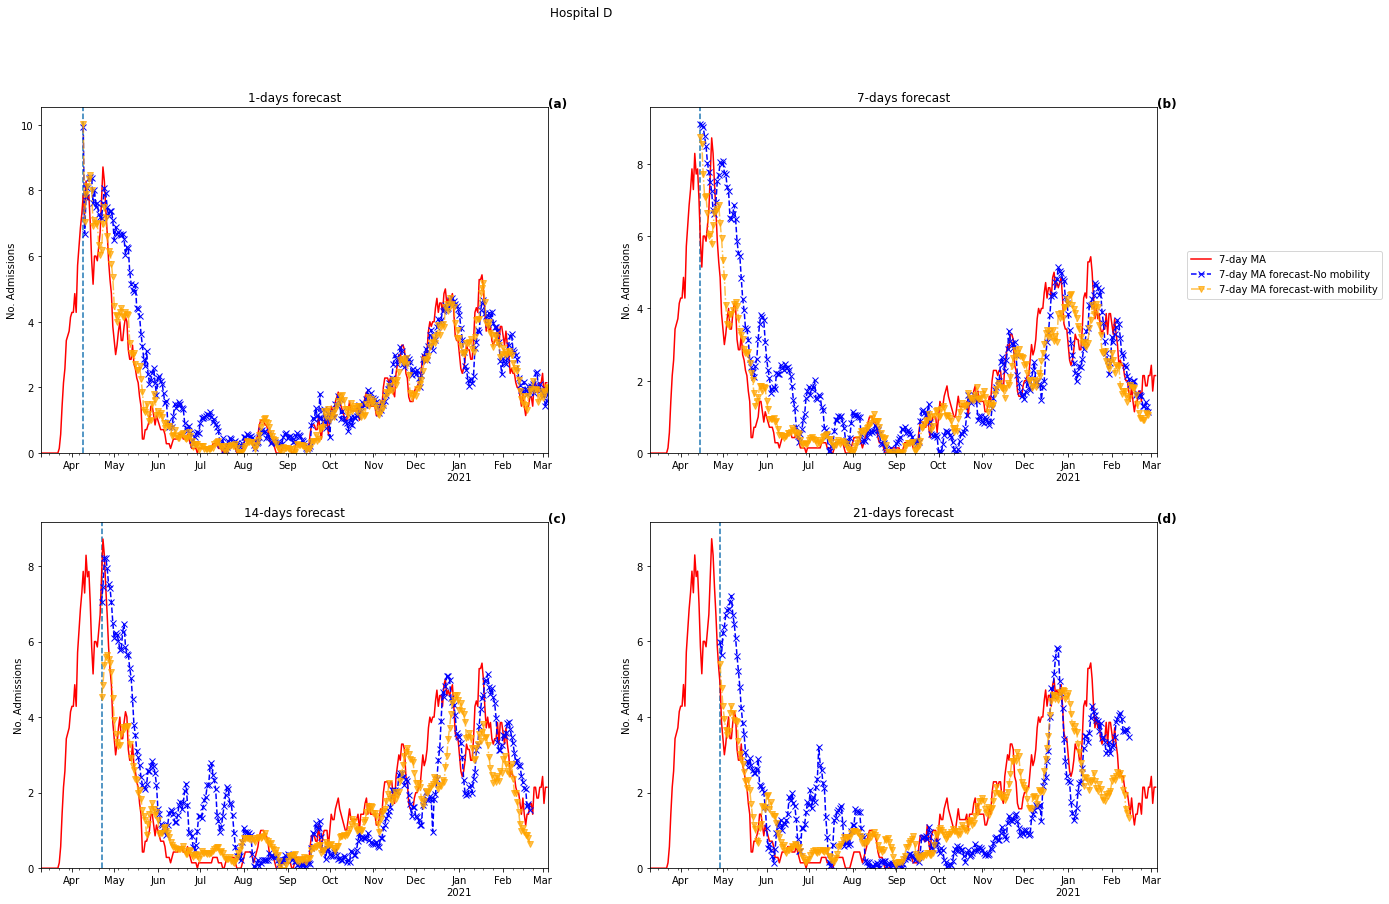

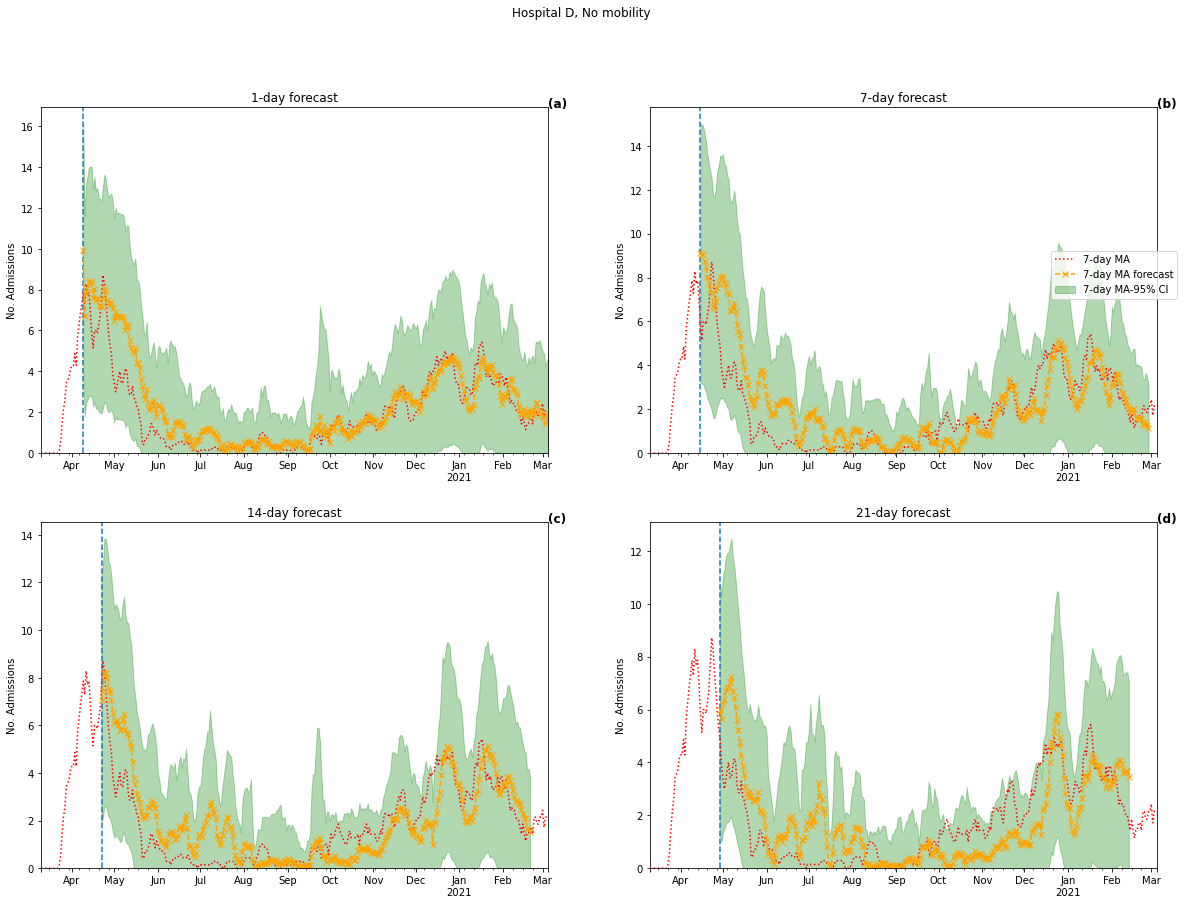

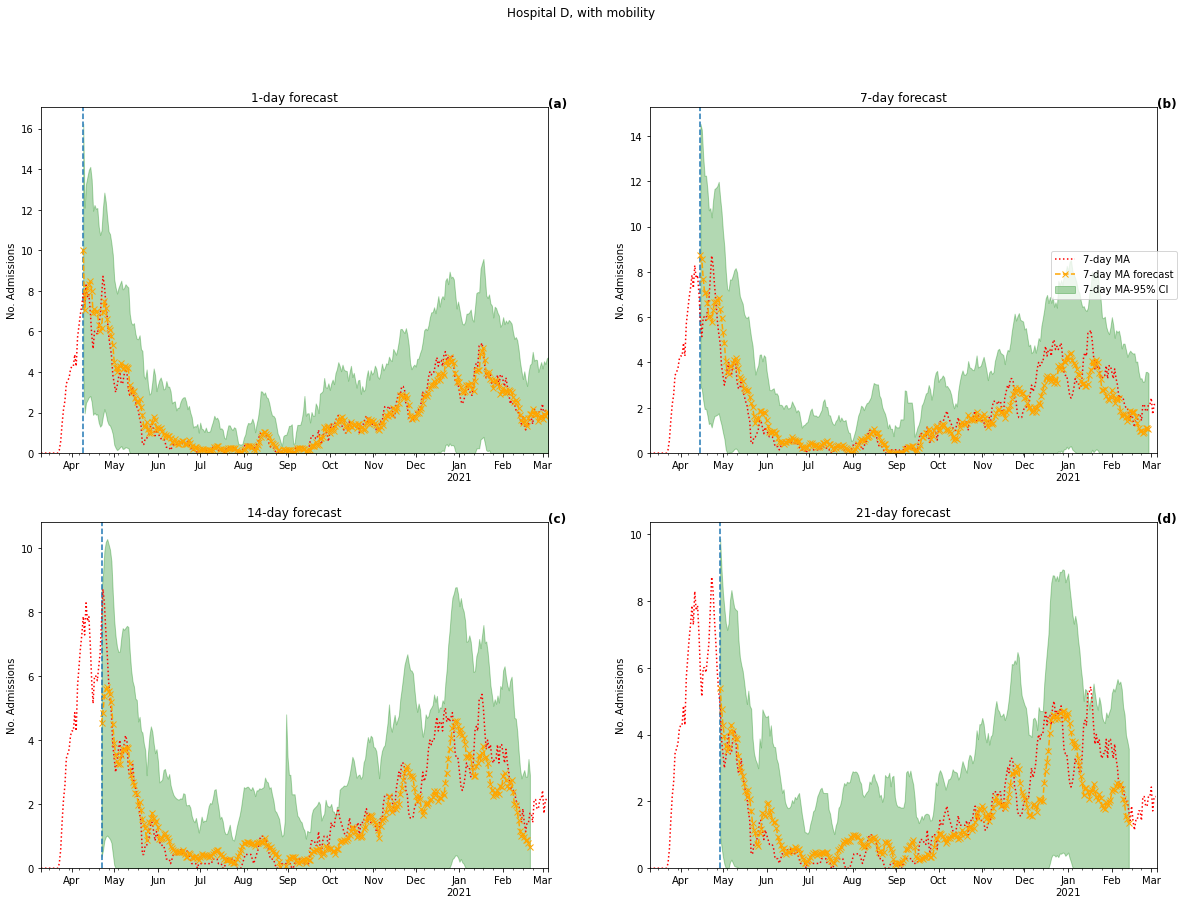

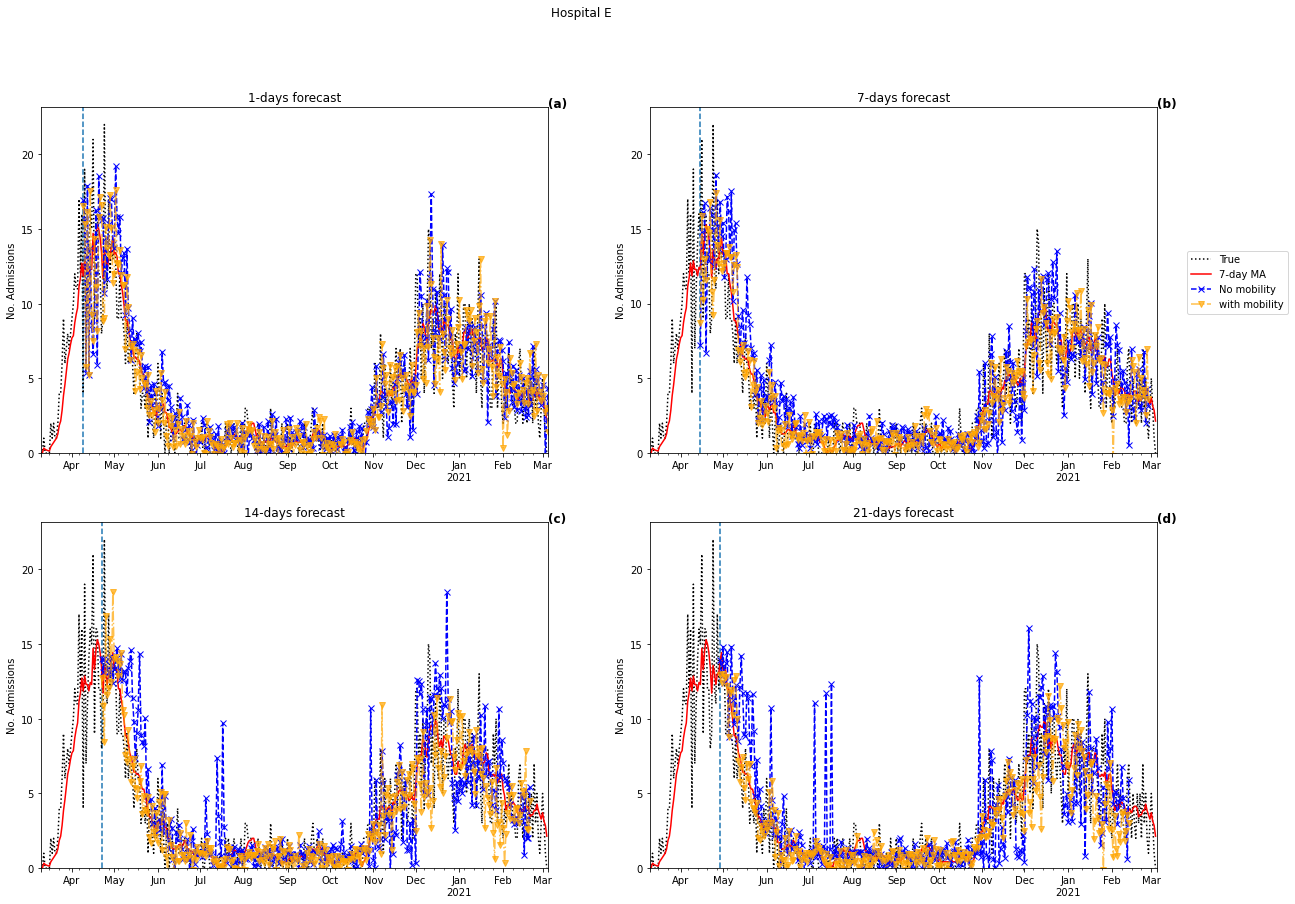

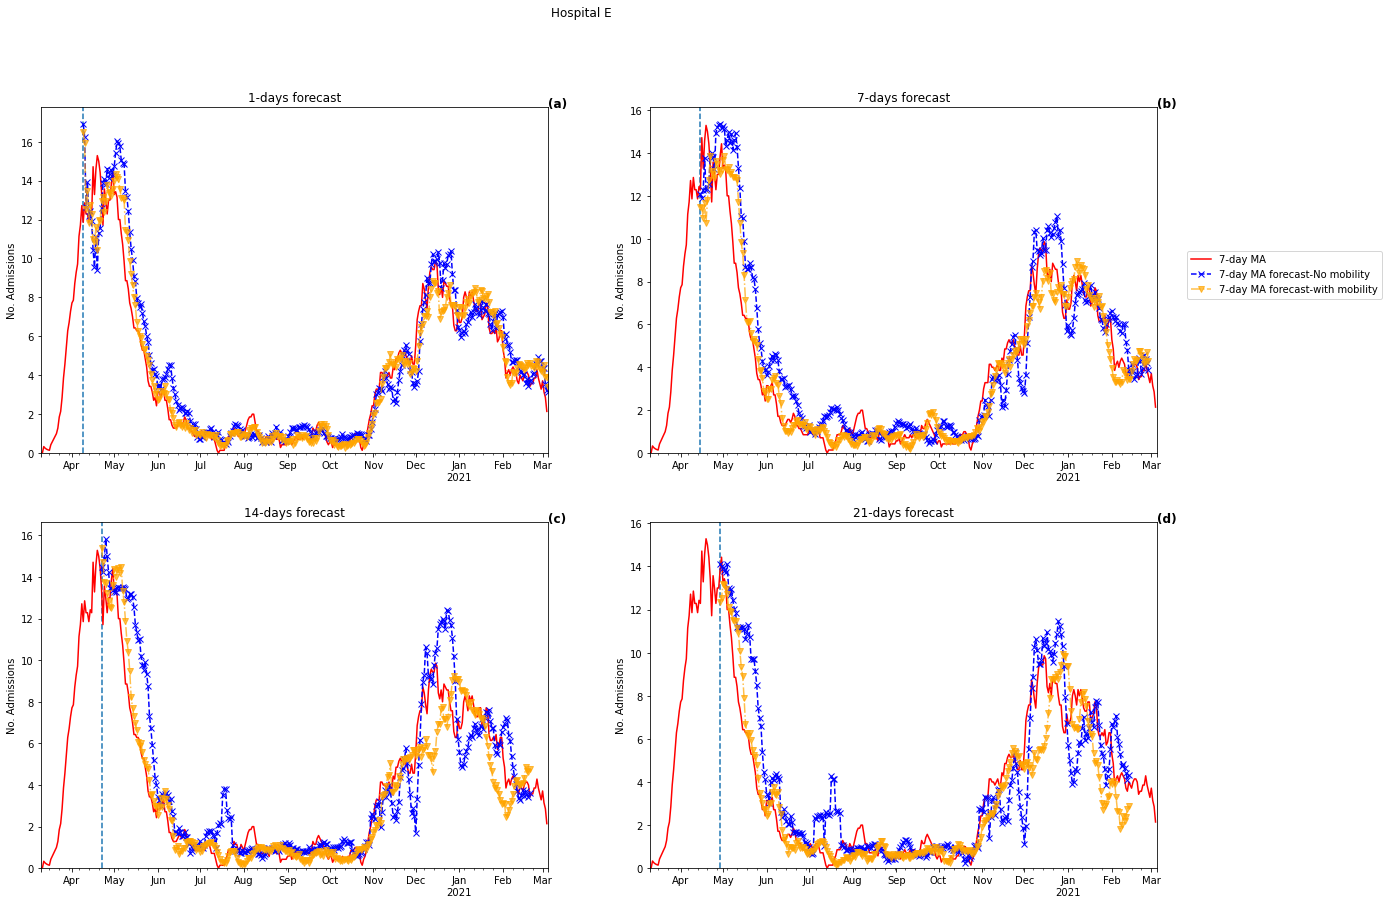

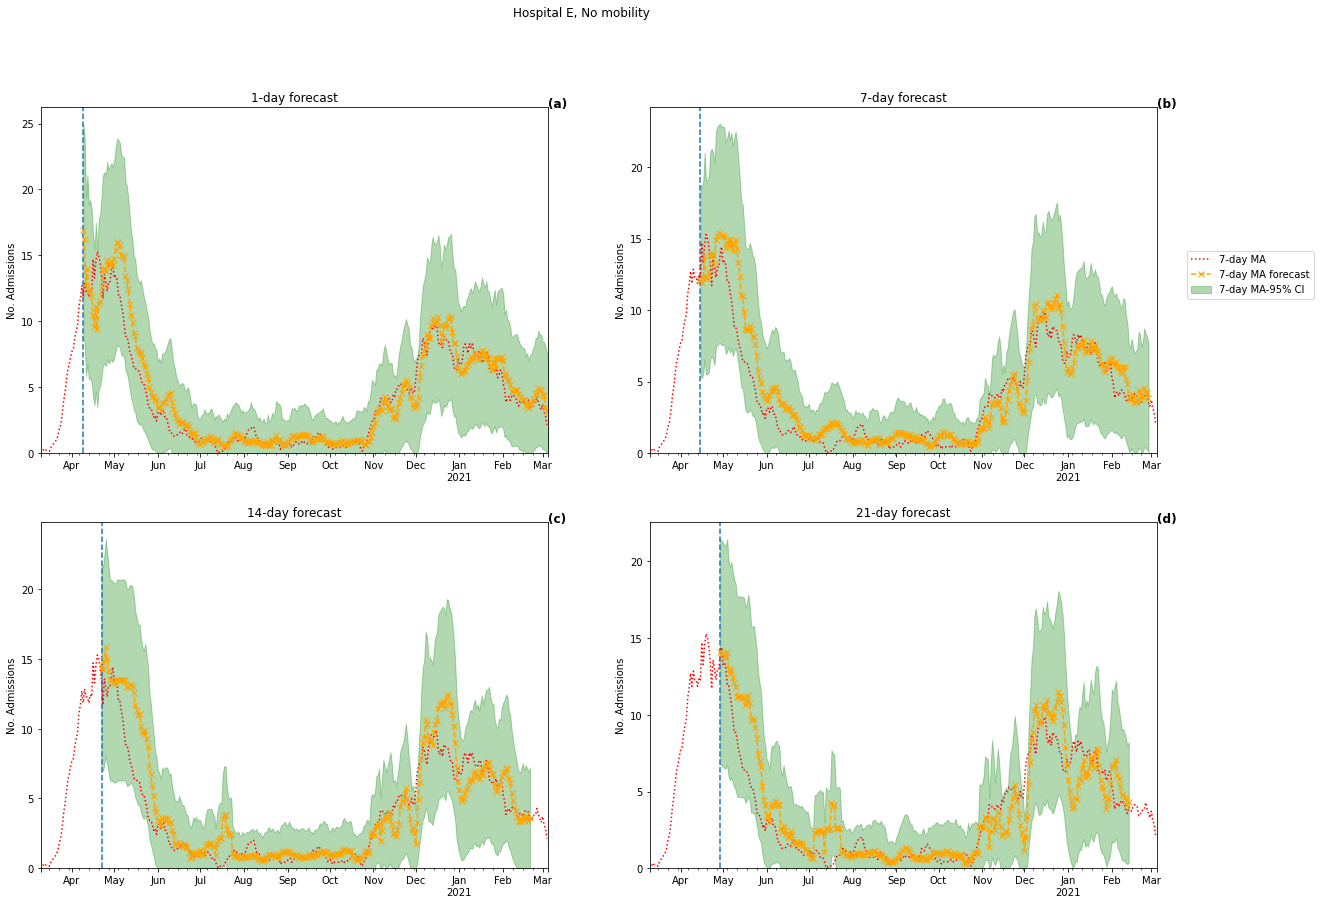

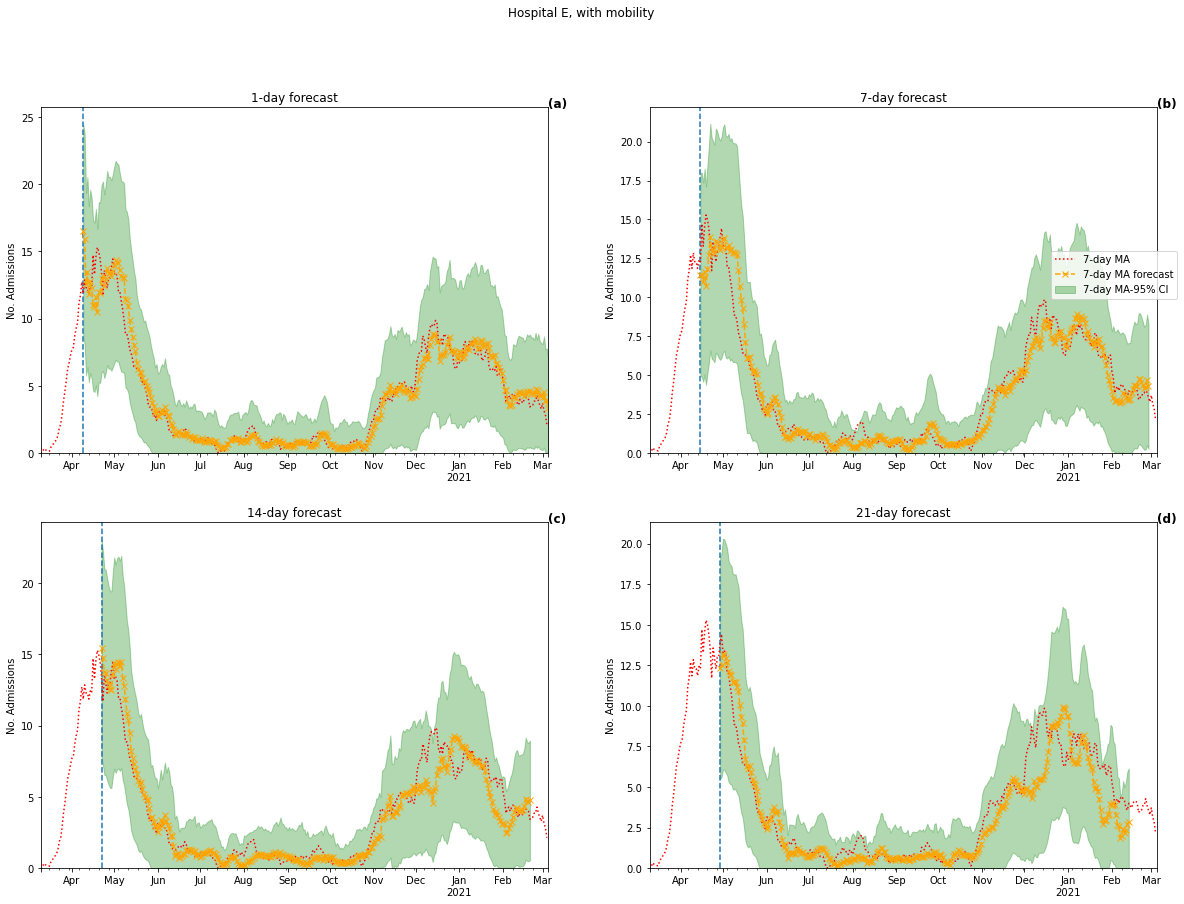

In [22]:
for target_col in "ABCDE":

    print(f"... processing hospital {target_col}")

    filePath=pathlib.Path(f"hosp_{target_col}")
    filePath.mkdir(parents=True, exist_ok=True)
    # No exogeneous
    predictions= forecast_each_hospital(df, target_col=target_col, exog_cols=None)
    #  exogeneous
    predictions_exog=forecast_each_hospital(df, target_col=target_col, exog_cols=mobility_cols)
    
    forecast_by_steps= get_forecast_by_steps(predictions)
    forecast_by_steps_exog= get_forecast_by_steps(predictions_exog)
    #
    save_predictions(filePath.name+f"/{target_col}_no_exog.pk", forecast_by_steps, nums= [0, 6, 13, 20])
    save_predictions(filePath.name+f"/{target_col}_exog.pk", forecast_by_steps_exog, nums= [0, 6, 13, 20])
    #
    fig, ax= plot_compare(target_col, forecast_by_steps, forecast_by_steps_exog)
    plt.savefig(filePath.name+"/comp.jpg", dpi=300, bbox_inhex="tight")
    #
    fig, ax=plot_compare_rolling(target_col, forecast_by_steps, forecast_by_steps_exog)
    plt.savefig(filePath.name+"/comp_rolling.jpg", dpi=300, bbox_inches="tight")
    #
    fig, ax=plot_with_ci_rolling(target_col, df, forecast_by_steps)
    fig.suptitle(f"Hospital {target_col}, No mobility")
    plt.savefig(filePath.name+"/rolling_7_no_exog.jpg", dpi=300, bbox_inches="tight")
    #
    fig, ax=plot_with_ci_rolling(target_col, df, forecast_by_steps_exog)
    fig.suptitle(f"Hospital {target_col}, with mobility")
    plt.savefig(filePath.name+"/rolling_7_exog.jpg", dpi=300, bbox_inches="tight")
    end_train= df.index[0] + datetime.timedelta(days=28)
    metrics_df= get_metrics(target_col, df, forecast_by_steps, forecast_by_steps_exog)
    metrics_df.to_csv(filePath.name+f"/metric_hops{target_col}.csv")

In [25]:
import shutil
#
for target in "ABCDE":
    src= f"/content/hosp_{target}"
    dest=f"/content/hosp_{target}"
    path_to_archive=shutil.make_archive(dest, "zip", src)
    print(path_to_archive)

FileNotFoundError: [Errno 2] No such file or directory: '/content/hosp_A'

In [ ]:
# dlag = 11
# cov_pri = df_ad.loc[df_ad['COVID_Encounter_Ref']=='covid_prim'].groupby('HospitalAdmitDate').agg({'NumberOfAdmissions':'sum'})
# cov_sec = df_ad.loc[df_ad['COVID_Encounter_Ref']=='covid_second'].groupby('HospitalAdmitDate').agg({'NumberOfAdmissions':'sum'})
# cov_pri = cov_pri.asfreq("D").fillna(0)
# cov_sec = cov_sec.asfreq("D").fillna(0)
# cov_adm = cov_pri.reset_index().merge(cov_sec.reset_index(), how='left', on='HospitalAdmitDate')
# cov_adm.columns = ['date','covid_primary','covid_secondary']

# lagged_commute = df_mobility.reset_index()[['date','commuters_per_home_user_percent']].copy()
# lagged_commute['date'] = lagged_commute['date'] + pd.DateOffset(days=dlag)
# cov_adm = cov_adm.merge(lagged_commute, how='left', on='date').dropna()

# cov_adm = cov_adm.loc[(cov_adm['date']>='2020-06-03')&(cov_adm['date']<='2020-12-05')].copy()
# cov_adm = cov_adm.set_index('date')
# cov_admw = cov_adm.resample('W').mean()

# fig, ax = plt.subplots(1,2,figsize=(6.75,2.75),dpi=170,sharex=True)
# plt.subplots_adjust(wspace=0.2)

# commvals = cov_adm['commuters_per_home_user_percent'].rolling(window=7).mean().dropna().values
# primvals = cov_adm['covid_primary'].rolling(window=7).mean().dropna().values
# secovals = cov_adm['covid_secondary'].rolling(window=7).mean().dropna().values
# commvals = cov_adm['commuters_per_home_user_percent'].rolling(window=1).mean().dropna().values
# primvals = cov_adm['covid_primary'].rolling(window=1).mean().dropna().values
# secovals = cov_adm['covid_secondary'].rolling(window=1).mean().dropna().values

# commvals = cov_admw['commuters_per_home_user_percent'].values
# primvals = cov_admw['covid_primary'].values*7
# secovals = cov_admw['covid_secondary'].values*7

# slprim,inprim,rprim,pprim,_ = linregress(commvals,primvals)
# slseco,inseco,rseco,pseco,_ = linregress(commvals,secovals)
# # rprim,pprim = pearsonr(commvals,primvals)
# # rseco,pseco = pearsonr(commvals,secovals)
# xreg = np.array([commvals[0],commvals[-1]])
# xreg = np.array([0.28,0.61])

# ax[0].scatter(commvals,primvals,c=np.linspace(0,1,len(primvals)),cmap='Spectral',ec='.2')
# ax[0].plot(xreg,xreg*slprim+inprim,lw=lw*2,alpha=0.7,color='.7',
#               label=r"$r^2 = %.3f$; "%(rprim**2)+r"$(p = 10^{-8})$", zorder=0)
# im = ax[1].scatter(commvals,secovals,c=np.linspace(0,1,len(primvals)),cmap='Spectral',ec='.2')
# ax[1].plot(xreg,xreg*slseco+inseco,lw=lw*2,alpha=0.7,color='.7',
#               label=r"$r^2 = %.3f$; "%(rseco**2)+r"$(p = 0.105)$", zorder=0)

# ax[0].set_title('COVID-19 Primary Admissions', color=label_cols['main'], fontsize=fs)
# ax[1].set_title('COVID-19 Secondary Admissions', color=label_cols['main'], fontsize=fs)
# ax[0].set_ylabel('New hospitalizations\n(Boston-area, weekly sum)',fontsize=fs*0.9, color=label_cols['main'])
# ax[0].set_xlabel('Commute volume (%i-day lag)\n(Boston-area, weekly average)'%dlag,fontsize=fs*0.9, color=label_cols['main'])
# ax[1].set_xlabel('Commute volume (%i-day lag)\n(Boston-area, weekly average)'%dlag,fontsize=fs*0.9, color=label_cols['main'])

# dlist = np.array([date_dict[str(i)[:10]] for i in cov_adm.index])
# mlist = np.array([date_dict[str(i)[:10]] for i in cov_adm.index if str(i)[:10][-2:]=='01'])
# mticks = np.array([np.where(dlist==i)[0][0] for i in mlist])/len(dlist)

# for ai, a in enumerate(fig.axes):
#     a.set_ylim(0, 240)
#     a.set_xlim(0.28, 0.61)
#     a.tick_params(which='both', labelsize=fs*0.8,
#                   labelcolor=label_cols['tick'], color=label_cols['tick'])
#     a.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
#     a.legend(loc=2, fontsize=8)
#     a.grid(color='.8', alpha=al, lw=lw/3)

# cbar_ax = fig.add_axes([0.915, 0.125, 0.015, 0.75])
# cbar = fig.colorbar(im, ax=ax[1],cax=cbar_ax, ticks=mticks)
# cbar.ax.set_yticklabels(['Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=fs*0.8,color=label_cols['tick'])


# plt.savefig('../figs/pngs/correlating_commutes_primsec.png', dpi=425, bbox_inches='tight')
# plt.savefig('../figs/pdfs/correlating_commutes_primsec.pdf', bbox_inches='tight')
# plt.show()